# Introduction
We're gonna be working with  Amazon review data. The goal of this project is to create a classifier that predicts the ratings of a product. We will be using NLP to evaluate the text of the review and determine whether the review was positive,negative or neutral. 

First let's download the data

In [1]:
!wget http://34.82.108.37/amazonReviewsTrain.csv.zip

--2023-04-11 16:01:29--  http://34.82.108.37/amazonReviewsTrain.csv.zip
Connecting to 34.82.108.37:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39456705 (38M) [application/zip]
Saving to: ‘amazonReviewsTrain.csv.zip.1’

amazonReviewsTrain. 100%[===================>]  37.63M  14.5MB/s    in 2.6s    

2023-04-11 16:01:31 (14.5 MB/s) - ‘amazonReviewsTrain.csv.zip.1’ saved [39456705/39456705]



In [2]:
!wget http://34.82.108.37/amazonReviewsTest.csv

--2023-04-11 16:01:31--  http://34.82.108.37/amazonReviewsTest.csv
Connecting to 34.82.108.37:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4240573 (4.0M) [application/octet-stream]
Saving to: ‘amazonReviewsTest.csv.1’

amazonReviewsTest.c 100%[===================>]   4.04M  3.73MB/s    in 1.1s    

2023-04-11 16:01:33 (3.73 MB/s) - ‘amazonReviewsTest.csv.1’ saved [4240573/4240573]



In [3]:
!unzip amazonReviewsTrain.csv.zip

Archive:  amazonReviewsTrain.csv.zip
replace amazonReviewsTrain.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: amazonReviewsTrain.csv  


In [4]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from keras import callbacks

Let's take a look at what type of features we're working with.

In [35]:
train_data = pd.read_csv('/content/amazonReviewsTrain.csv')
test_data = pd.read_csv('/content/amazonReviewsTest.csv')
# train_data.loc[train_data['rating'] == 'negative']
train_data


<ipython-input-35-48182549acad>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/content/amazonReviewsTrain.csv')


,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,rating
0,True,"05 4, 2017",A2QNLVLQHW6OOC,B00NEZNT74,Jason L.,Have 30 of these in operation great lights,Five Stars,1493856000,NaN,{'Size:': ' 4PC'},NaN,positive
1,True,"12 1, 2014",A32SHV461SUWNQ,B002Q0WTCE,Richard C.,"Good replacement. I prefer my Rovner L5, but ...",Good replacement. I prefer my Rovner L5,1417392000,NaN,NaN,NaN,positive
2,True,"12 23, 2015",A2SKHG5ULPYIMC,B0002GFP9I,BellaLatinaReina-ACP Zero-Nine-Five,My son & band teacher loves it. Really nice. B...,Really Helps With Their Practice Pad,1450828800,NaN,NaN,NaN,positive
3,True,"09 4, 2013",A2MFJ6C67AL015,B003AJVKDO,BOS116,This was a gift for a friend who is a fan of t...,Guitar picks,1378252800,NaN,{'Color:': ' Logo'},NaN,positive
4,True,"08 28, 2015",ACYCDUUE9A3T2,B004XNK7AI,jack edwards,Wish it would attach to my violin a little eas...,... to my violin a little easier but it works ...,1440720000,NaN,{'Color:': ' Black - SN-5'},NaN,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
221387,True,"08 16, 2015",A1TWEBKVZDD2JJ,B0002H05BA,Obey Giant,Still hard to beat D'Addario. Hope they keep i...,Five Stars,1439683200,NaN,"{'Size:': ' Regular Light, 10-46', 'Style:': '...",NaN,positive
221388,True,"01 8, 2012",AP32V2GXAK9VM,B000WME8C2,Grey,Ortofon hits the nail right on the head with t...,Headshell Impovment? YES!!!,1325980800,7.0,{'Color:': ' Black'},NaN,positive
221389,True,"10 22, 2017",A4BIHE0AYAMTP,B00MD7S06O,divbyzero,This is my absolute favorite guitar strap amon...,ecclesiastical / hippie,1508630400,NaN,NaN,['https://images-na.ssl-images-amazon.com/imag...,positive
221390,True,"01 9, 2016",A3OCE03MZ2PC2J,B0017PLYCK,scaper,nice,Five Stars,1452297600,NaN,NaN,NaN,positive


There seems to be a lot of features, but really we are only concerned with the `reviewText` and `rating` columns

In [33]:
# Extract the text and labels and encode the labels 
label_as_binary = LabelBinarizer()
review_text = train_data.reviewText.astype(str)
review_labels = train_data.rating

review_labels = label_as_binary.fit_transform(review_labels)
review_labels[9]




array([1, 0, 0])

We need to use a tokenizer to find 5000 of the most common words in the review. This number can change down the line if need be. Also, we use **tfidf** representation to place more importance on words that appear less frequently among all reviews (words like 'the', 'a', 'this', etc.).

In [13]:
numwords = 5000
tokenizer = Tokenizer(num_words=numwords)
tokenizer.fit_on_texts(review_text)
# One hot encode the tokenized text
results = tokenizer.texts_to_matrix(review_text, mode='tfidf')



In [14]:
# split the data into training and test
review_train_text, review_test_text, review_train_labels, review_test_labels = train_test_split(results, review_labels, test_size = 0.3, random_state=11)

# Building the network
We need to build a network now. Although the network seems fairly simple, a lot of work was done to get here. We have two Dense layers, two Dropout layers and one softmax output layer. The network uses the 'adam' optimizer. So why did I choose these specific layers? I initially started with 2 Dense layers(size of 256 and 128 respectively) and a single output layer. The issue was my model was overfitting like crazy. So like all good programmers I went to Google and researched ways to prevent overfitting. One method I found was to reduce the size of the layers. So I experimented with smaller and smaller sizes until I found the sweet spot of 16 and 8. Another method was to add Dropout layers.

Dropout is a method of where random neurons are randomly "dropped" out during training. As a neural network is learning, neuron weights tend to stay within the their own context. Neighbouring neurons will rely on this and in turn lead to a model that has become too familiar with the training data (aka overfitting). Ignoring random neurons help mitigate this. Which is why we have two Dropout layers, one after each Dense layer.

With those two techniques I managed to go from a loss of around .68 to a loss of roughly .30! Additionally, I removed my issue of overfitting.

In [15]:

network2 = models.Sequential()
network2.add(layers.Dense(16, activation='relu', input_shape=(5000,)))
network2.add(layers.Dropout(0.3))
network2.add(layers.Dense(8, activation='relu'))
network2.add(layers.Dropout(0.3))
network2.add(layers.Dense(3, activation='softmax'))




network2.compile(optimizer='adam',loss='categorical_crossentropy',
                metrics=['accuracy'])



In [16]:

history2 = network2.fit(
      review_train_text, review_train_labels,
      steps_per_epoch=100,
      epochs=30,
      validation_split=0.3,
      validation_steps=50,
      batch_size=128
      )

Epoch 1/30
100/100 [==============================] - 8s 25ms/step - loss: 0.7802 - accuracy: 0.8397 - val_loss: 0.5133 - val_accuracy: 0.8656
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.5135 - accuracy: 0.8617 - val_loss: 0.3857 - val_accuracy: 0.8656
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4392 - accuracy: 0.8658 - val_loss: 0.3591 - val_accuracy: 0.8656
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4087 - accuracy: 0.8673 - val_loss: 0.3470 - val_accuracy: 0.8656
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3898 - accuracy: 0.8685 - val_loss: 0.3394 - val_accuracy: 0.8656
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3904 - accuracy: 0.8696 - val_loss: 0.3323 - val_accuracy: 0.8656
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3782 - accuracy: 0.8728 - val_loss: 0.3285 - val_accuracy: 0.8714
Epoch

Let's take a look at the model's accuracy on the test set

In [17]:
scoreSeg = network2.evaluate(review_test_text, review_test_labels)
print("Accuracy: ", scoreSeg[1])

2076/2076 [==============================] - 5s 2ms/step - loss: 0.3299 - accuracy: 0.8920
Accuracy:  0.8919870853424072


An accuracy of 89% with a relatively small loss of 0.32. Not bad at all. Let's take a look at the graph and check for any overfitting.

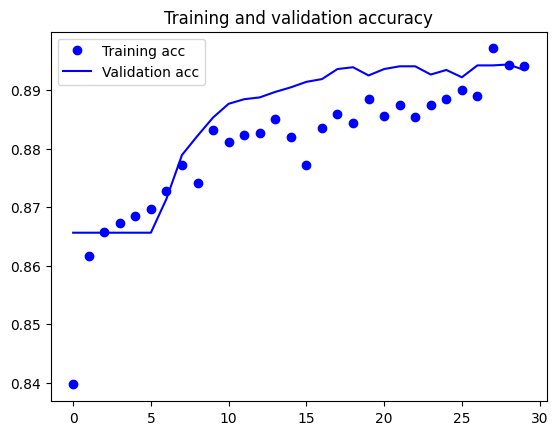

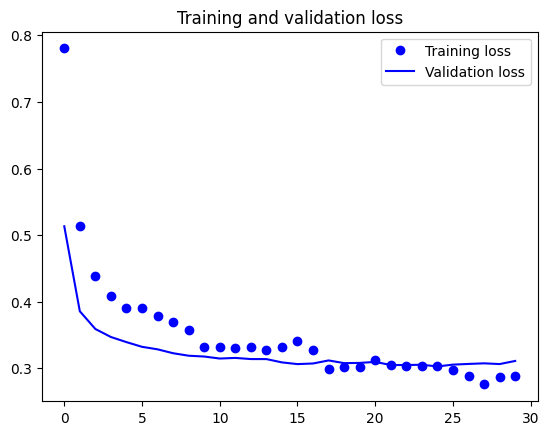

In [18]:


acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



It looks like there isn't any overfitting going on with the way the validation and training lines converge. Great! Let's run our model on the test.csv we downloaded earlier and place the predictions in a text file for submission.

In [ ]:
tokenizer_test = Tokenizer(num_words=5000)
review_text_test = test_data.reviewText.astype(str)
tokenizer_test.fit_on_texts(review_text_test)
results2 = tokenizer_test.texts_to_matrix(review_text_test, mode='tfidf')


In [ ]:
# stores the array of predicted probabilities in an array
y_prob = network2.predict(results2)
# stores the associated class of the prediction 
y_classes = y_prob.argmax(axis=-1)


In [43]:
# writes the label of the class into a list
predictions = []
for i in y_classes:
  if i == 0:
    predictions.append('negative')
  elif i == 1:
    predictions.append('neutral')
  else:
    predictions.append('positive')


Out of curiousty, I took a look at what values I got and found some interesting results. 9690 positive predictions and 310 negative predictions. At first I thought that there was something wrong with my model but... if you look at amazon you will find many products actually have more positive reviews than negative. But the skew towards positive seems excessive. 

In [44]:
predictions = pd.Series(predictions).value_counts()
predictions

positive    9690
negative     310
dtype: int64

In [37]:
# saves the list into a text file
with open(r'/content/amazonReviewsPredictions.txt', 'w') as fp:
    for item in predictions:
        # write each item on a new line
        fp.write("%s\n" % item)
    

In [38]:
# test the format of the file
def test():
  i = 0
  answers = ['negative', 'neutral', 'positive']
  with open('/content/amazonReviewsPredictions.txt', 'r') as outfile:
    lines = outfile.readlines()
    for line in lines:
        if line.strip() not in answers:
          return("invalid entry line %i" % (i))
        i += 1
    if i != 10000:
      return ("incorrect number of lines")
    else:
      return ("file looks ok")
test()

'file looks ok'